#Домашнее задание № 4. Модели авторегрессии условной гетероскедантичности.

##Загрузим необходимые данные

In [129]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.tsa.api as smt

In [130]:
# загрузим данные
!wget 'https://u.netology.ru/backend/uploads/lms/attachments/files/data/47497/1._Лекция_tsml.zip'

--2025-02-25 14:45:56--  https://u.netology.ru/backend/uploads/lms/attachments/files/data/47497/1._%D0%9B%D0%B5%D0%BA%D1%86%D0%B8%D1%8F_tsml.zip
Resolving u.netology.ru (u.netology.ru)... 213.180.193.247, 2a02:6b8::1da
Connecting to u.netology.ru (u.netology.ru)|213.180.193.247|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 769056 (751K) [application/x-zip-compressed]
Saving to: ‘1._Лекция_tsml.zip.1’

1._Лекция_tsml.zip. 100%[===================>] 751.03K   346KB/s    in 2.2s    

2025-02-25 14:46:00 (346 KB/s) - ‘1._Лекция_tsml.zip.1’ saved [769056/769056]



In [131]:
# распакуем
import zipfile

with zipfile.ZipFile('/content/1._Лекция_tsml.zip', 'r') as zip_ref:
    zip_ref.extractall('unpacked_files')

В качестве ряда для анализа выберу monthly_boston_armed_robberies_j. Он мне кажется самым интересным.

In [132]:
# 2. ежемесячные_бостонские вооруженные_ ограбления_j
monthly_boston_armed_robberies_j = pd.read_csv('/content/unpacked_files/Series/monthly-boston-armed-robberies-j.csv')

In [133]:
series = monthly_boston_armed_robberies_j['Count']

In [134]:
# вывод графиков
def chart_2(series_1, series_2=None, title=None):
    plt.figure(figsize=(14, 7))
    plt.plot(series_1, label='Временной ряд')
    if series_2 is not None:
        plt.plot(series_2, label=title)
    plt.title('Визуальное сравнение полученного временного ряда')
    plt.xlabel('Время')
    plt.ylabel('Величина')
    plt.grid(False)
    plt.legend()
    plt.show()

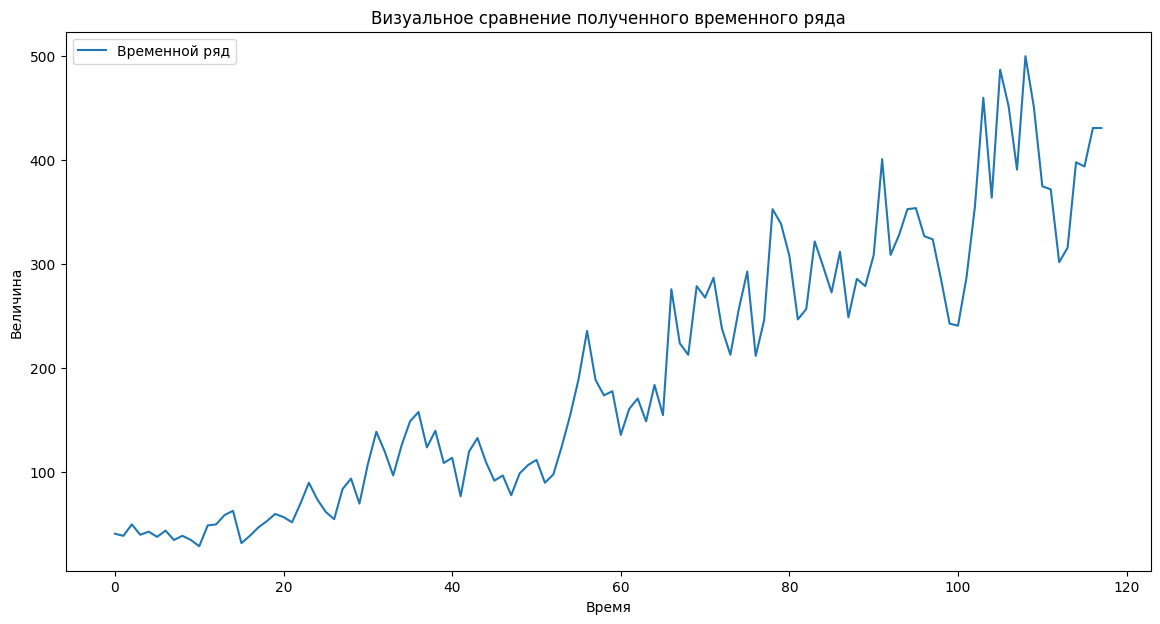

In [135]:
# еще раз на него посмотрим
chart_2(series)

Скопирую функции для анализа ряда

In [136]:
def test_stationarity(timeseries):
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for [key, value] in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

In [137]:
def tsplot(y, lags=None, figsize=(14, 8), style='bmh'):
    test_stationarity(y)
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):
        plt.figure(figsize=figsize)
        layout = (5, 1)
        ts_ax = plt.subplot2grid(layout, (0, 0), rowspan=2)
        acf_ax = plt.subplot2grid(layout, (2, 0))
        pacf_ax = plt.subplot2grid(layout, (3, 0))
        qq_ax = plt.subplot2grid(layout, (4, 0))

        y.plot(ax=ts_ax, color='blue', label='Or')
        ts_ax.set_title('Original')

        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.05)
        sm.qqplot(y, line='s', ax=qq_ax)

        plt.tight_layout()
    return

##Модель GARCH

##Вариант 1.

---



In [138]:
# загрузим библиотеки
from statsmodels.tsa.arima.model import ARIMA
import itertools

In [153]:
# отключаем сообщения об ошибках
import warnings
warnings.filterwarnings('ignore')

# для поиска наилучших параметров воспользуемся поиском по сетке
p = range(0,15)
d = q = range(0,3)
pdq = list(itertools.product(p, d, q))
print(f'Всего рассмотрим {len(pdq)} вариантов')
best_pdq = (0,0,0)

# для поиска лучшей модели воспользуемся информационным критерием aic.
# AIC — Akaike Information Criterion). AIC оценивает, насколько хорошо модель подходит под данные.
# чем меньше AIC – тем точнее модель
best_aic = np.inf

for params in pdq:
    model_test = ARIMA(series, order=params)
    result_test = model_test.fit()

    if result_test.aic < best_aic:
        best_pdq = params
        best_aic = result_test.aic
        result_1 = result_test
print(f'модель ARIMA(p,d,q): p={best_pdq[0]}, d={best_pdq[1]}, g={best_pdq[2]}, best_aic{best_aic}')

Всего рассмотрим 135 вариантов
модель ARIMA(p,d,q): p=11, d=2, g=1, best_aic1170.5123599546882


In [154]:
# проверим оптимальность модели
result_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Count   No. Observations:                  118
Model:                ARIMA(11, 2, 1)   Log Likelihood                -572.256
Date:                Tue, 25 Feb 2025   AIC                           1170.512
Time:                        14:51:18   BIC                           1206.309
Sample:                             0   HQIC                          1185.044
                                - 118                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4821      0.096     -4.998      0.000      -0.671      -0.293
ar.L2         -0.4306      0.081     -5.336      0.000      -0.589      -0.272
ar.L3         -0.2631      0.110     -2.402      0.016      -0.478      -0.048
ar.L4         -0.4375      0.104     -4.189      0.000      -0.642      -0.233
ar.L5         -0.2273      0.109     -2.077      0.038      -0.442      -0.013
ar.L6         -0.3339      0.096     -3.461      0.001      -0.523      -0.145
ar.L7         -0.4220      0.101     -4.198      0.000      -0.619      -0.225
ar.L8         -0.2848      0.117     -2.440      0.015      -0.513      -0.056
ar.L9         -0.3873      0.112     -3.447      0.001      -0.608      -0.167
ar.L10        -0.4829      0.130     -3.709      0.000      -0.738      -0.228
ar.L11        -0.2770      0.100     -2.767      0.006      -0.473      -0.081
ma.L1         -0.9689      0.034    -28.236      0.000      -1.036      -0.902
sigma2      1041.5759    125.746      8.283      0.000     795.119    1288.033
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                21.30
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):               5.56   Skew:                             0.72
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.53
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Здесь нас интересует таблица коэффициентов. Столбец coef показывает влияние каждого параметра на временной ряд, а P>|z| — значимость. Чем ближе значение P>|z| к нулю, тем выше значимость.

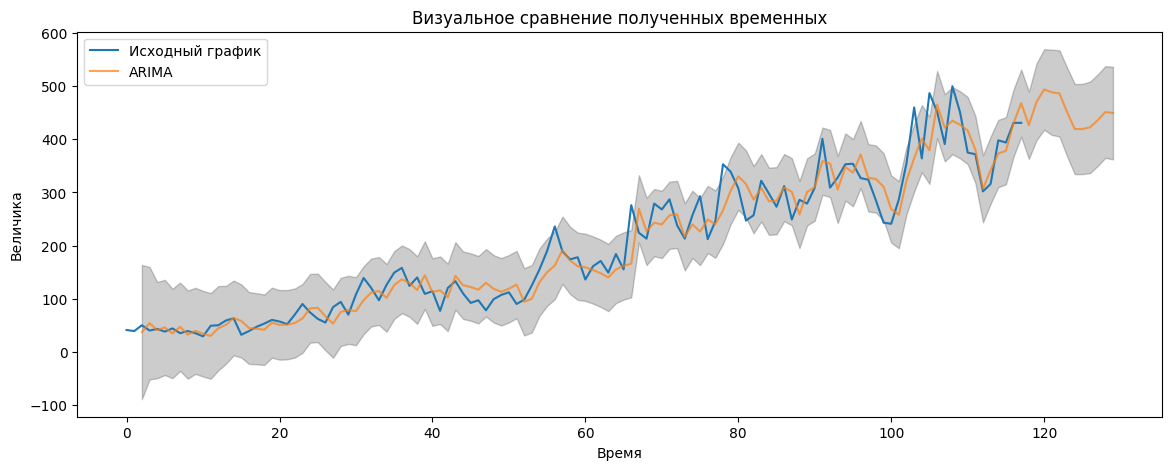

In [155]:
# посмотрим
pred = result_1.get_prediction(start=2, end=129, dynamic=False)
pred_ci = pred.conf_int()

ax = series.plot(label='Исходный график', figsize=(14, 5))
pred.predicted_mean.plot(ax=ax, label='ARIMA', alpha=.7)
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2
               )
plt.title('Визуальное сравнение полученных временных')
ax.set_xlabel('Время')
ax.set_ylabel('Величика')
plt.legend()
plt.show()

Вторым методом модели, который может помочь в оценке модели — plot_diagnostics().

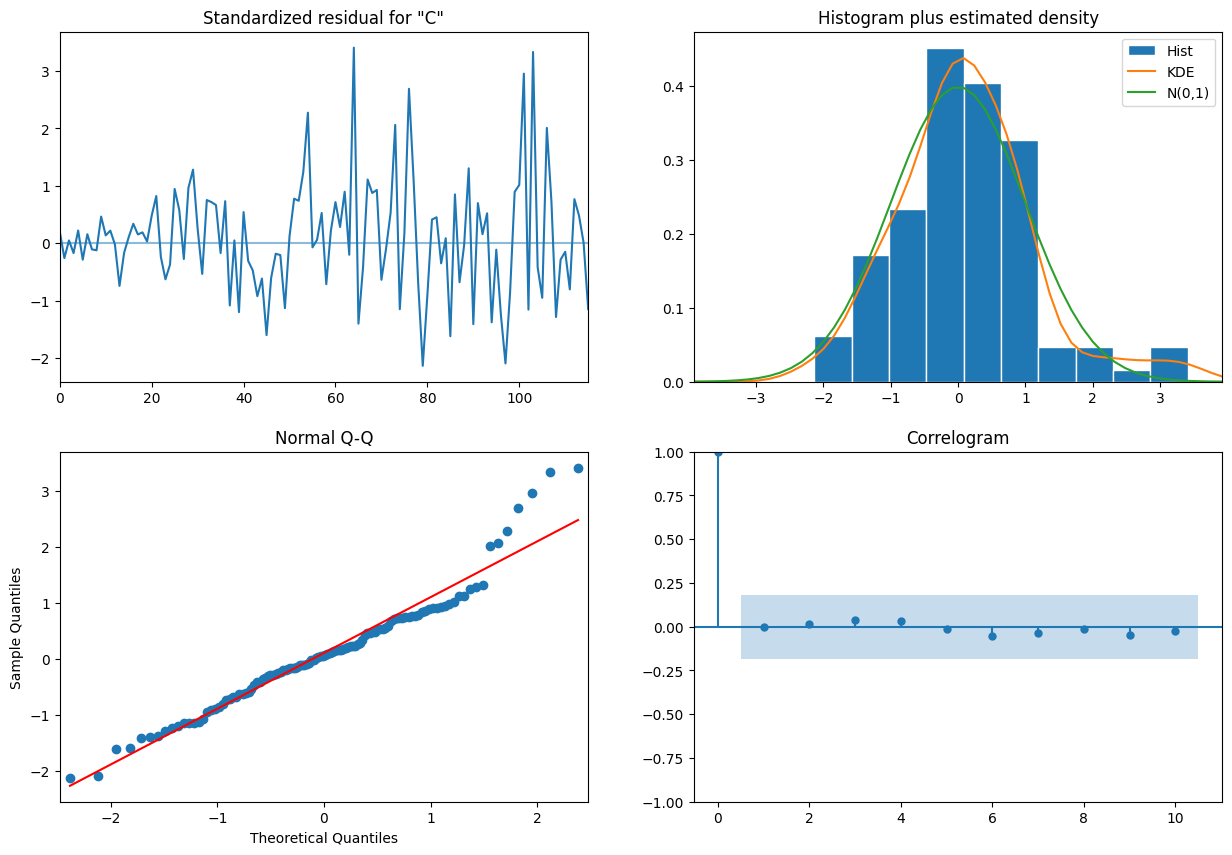

In [156]:
result_1.plot_diagnostics(figsize=(15, 10))
plt.show()

Results of Dickey-Fuller Test:
Test Statistic                -1.084819e+01
p-value                        1.552920e-19
#Lags Used                     0.000000e+00
Number of Observations Used    1.170000e+02
Critical Value (1%)           -3.487517e+00
Critical Value (5%)           -2.886578e+00
Critical Value (10%)          -2.580124e+00
dtype: float64


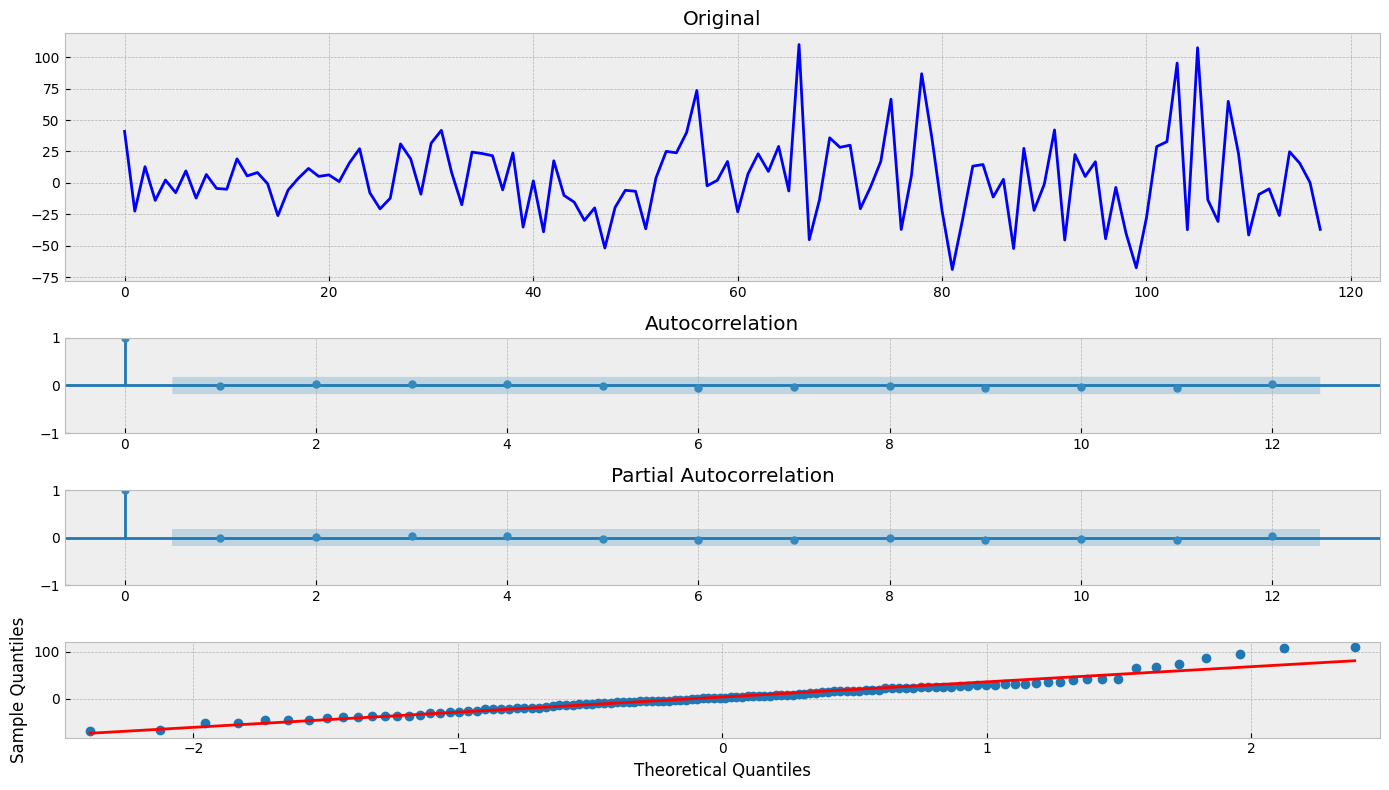

In [158]:
# проверим функцией из лекции
tsplot(result_1.resid, lags=12)

Остатки имеют нормальное распределение и близкую к нулю автокорреляцию.



Подгоним модель GARCH.

In [159]:
!pip install arch

In [160]:
# импортируем модель
from arch import arch_model

In [161]:
best_pdq

(11, 2, 1)

In [162]:
# используем найденные значения
p_ = best_pdq[0]
d_ = best_pdq[1]
q_ = best_pdq[2]

# используем T-распределения Стьюдента
am = arch_model(series, p=p_, o=d_, q=q_, dist='StudentsT')
result_2 = am.fit(update_freq=12, disp='off')
result_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                      Constant Mean - GJR-GARCH Model Results                       
====================================================================================
Dep. Variable:                        Count   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                        GJR-GARCH   Log-Likelihood:               -693.639
Distribution:      Standardized Student's t   AIC:                           1421.28
Method:                  Maximum Likelihood   BIC:                           1468.38
                                              No. Observations:                  118
Date:                      Tue, Feb 25 2025   Df Residuals:                      117
Time:                              14:53:49   Df Model:                            1
                                Mean Model                                
==========================================================================
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu           105.1746     23.307      4.512  6.407e-06 [ 59.493,1.509e+02]
                               Volatility Model                              
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega          4.0824    245.906  1.660e-02      0.987 [-4.779e+02,4.860e+02]
alpha[1]       0.9742      0.835      1.166      0.244      [ -0.663,  2.612]
alpha[2]   2.7994e-17      1.771  1.581e-17      1.000      [ -3.470,  3.470]
alpha[3]       0.0779      1.158  6.724e-02      0.946      [ -2.192,  2.347]
alpha[4]   3.7625e-14      3.286  1.145e-14      1.000      [ -6.441,  6.441]
alpha[5]       0.0179      0.618  2.898e-02      0.977      [ -1.193,  1.228]
alpha[6]       0.0371      0.543  6.828e-02      0.946      [ -1.027,  1.101]
alpha[7]   2.5032e-14      0.874  2.864e-14      1.000      [ -1.713,  1.713]
alpha[8]   2.8901e-17      0.904  3.198e-17      1.000      [ -1.771,  1.771]
alpha[9]   5.8696e-14      0.421  1.395e-13      1.000      [ -0.825,  0.825]
alpha[10]      0.1666      1.676  9.941e-02      0.921      [ -3.118,  3.451]
alpha[11]      0.0739      0.332      0.222      0.824      [ -0.577,  0.725]
gamma[1]      -0.9742      1.455     -0.669      0.503      [ -3.826,  1.878]
gamma[2]       0.1947      2.336  8.337e-02      0.934      [ -4.383,  4.773]
beta[1]    9.1645e-14      1.642  5.583e-14      1.000      [ -3.217,  3.217]
                                 Distribution                                
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
nu           421.8643    415.808      1.015      0.310 [-3.931e+02,1.237e+03]
=============================================================================

Covariance estimator: robust
"""

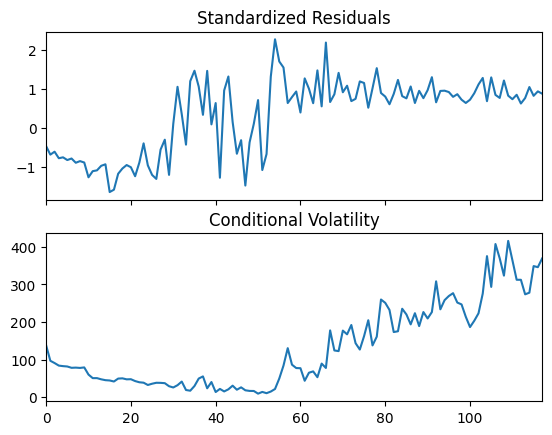

In [163]:
# визуально можно представить так
fig = result_2.plot()

Results of Dickey-Fuller Test:
Test Statistic                   1.001102
p-value                          0.994278
#Lags Used                      11.000000
Number of Observations Used    106.000000
Critical Value (1%)             -3.493602
Critical Value (5%)             -2.889217
Critical Value (10%)            -2.581533
dtype: float64


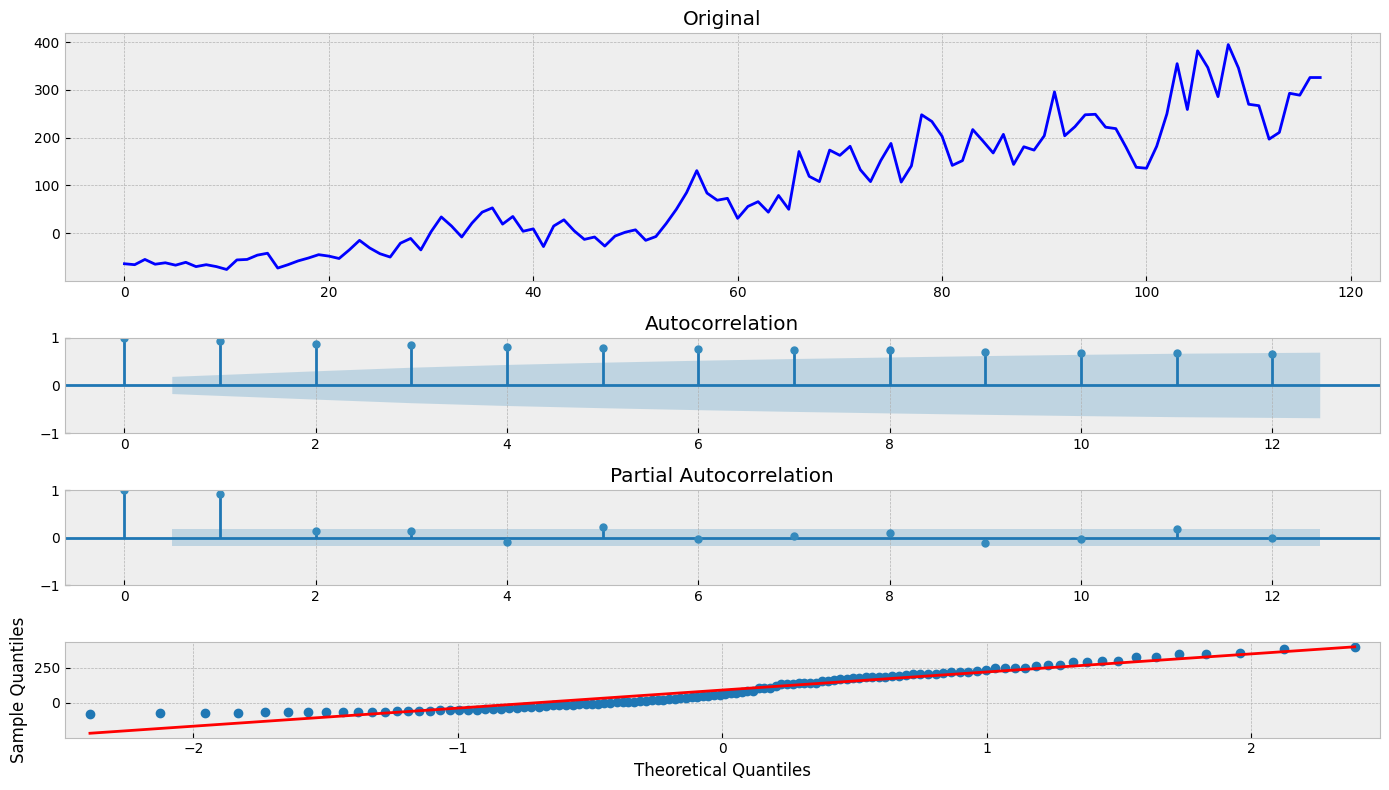

In [164]:
tsplot(result_2.resid, lags=12)

##Вариант 2.

In [150]:
# разобъем временной ряд на train/test
n_test = int(len(series)*0.2)
train, test = series[:-n_test], series[-n_test:]
train[:3], test[:3]

(0    41
 1    39
 2    50
 Name: Count, dtype: int64,
 95    354
 96    327
 97    324
 Name: Count, dtype: int64)

In [151]:
# определим модель
model = arch_model(train, mean='Zero', vol='GARCH', p=12, q=12)

# обучим модель
model_fit = model.fit()

# получим результат
result = am.fit(update_freq=12, disp='off')
result.summary()

Iteration:      1,   Func. Count:     27,   Neg. LLF: 598.5133369403887
Iteration:      2,   Func. Count:     53,   Neg. LLF: 598.409995837976
Iteration:      3,   Func. Count:     79,   Neg. LLF: 598.1332880824958
Iteration:      4,   Func. Count:    105,   Neg. LLF: 598.1972893538335
Iteration:      5,   Func. Count:    132,   Neg. LLF: 598.1274462527876
Iteration:      6,   Func. Count:    159,   Neg. LLF: 598.1168327113309
Iteration:      7,   Func. Count:    186,   Neg. LLF: 598.1162694730518
Iteration:      8,   Func. Count:    212,   Neg. LLF: 598.1162622072197
Iteration:      9,   Func. Count:    238,   Neg. LLF: 598.1162601778765
Iteration:     10,   Func. Count:    264,   Neg. LLF: 598.1162519620483
Iteration:     11,   Func. Count:    290,   Neg. LLF: 598.1162016943913
Iteration:     12,   Func. Count:    316,   Neg. LLF: 598.1160781027022
Iteration:     13,   Func. Count:    342,   Neg. LLF: 598.1156971749509
Iteration:     14,   Func. Count:    368,   Neg. LLF: 598.1150075

<class 'statsmodels.iolib.summary.Summary'>
"""
                      Constant Mean - GJR-GARCH Model Results                       
====================================================================================
Dep. Variable:                        Count   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                        GJR-GARCH   Log-Likelihood:               -693.639
Distribution:      Standardized Student's t   AIC:                           1421.28
Method:                  Maximum Likelihood   BIC:                           1468.38
                                              No. Observations:                  118
Date:                      Tue, Feb 25 2025   Df Residuals:                      117
Time:                              14:47:55   Df Model:                            1
                                Mean Model                                
==========================================================================
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu           105.1746     23.307      4.512  6.407e-06 [ 59.493,1.509e+02]
                               Volatility Model                              
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega          4.0824    245.906  1.660e-02      0.987 [-4.779e+02,4.860e+02]
alpha[1]       0.9742      0.835      1.166      0.244      [ -0.663,  2.612]
alpha[2]   2.7994e-17      1.771  1.581e-17      1.000      [ -3.470,  3.470]
alpha[3]       0.0779      1.158  6.724e-02      0.946      [ -2.192,  2.347]
alpha[4]   3.7625e-14      3.286  1.145e-14      1.000      [ -6.441,  6.441]
alpha[5]       0.0179      0.618  2.898e-02      0.977      [ -1.193,  1.228]
alpha[6]       0.0371      0.543  6.828e-02      0.946      [ -1.027,  1.101]
alpha[7]   2.5032e-14      0.874  2.864e-14      1.000      [ -1.713,  1.713]
alpha[8]   2.8901e-17      0.904  3.198e-17      1.000      [ -1.771,  1.771]
alpha[9]   5.8696e-14      0.421  1.395e-13      1.000      [ -0.825,  0.825]
alpha[10]      0.1666      1.676  9.941e-02      0.921      [ -3.118,  3.451]
alpha[11]      0.0739      0.332      0.222      0.824      [ -0.577,  0.725]
gamma[1]      -0.9742      1.455     -0.669      0.503      [ -3.826,  1.878]
gamma[2]       0.1947      2.336  8.337e-02      0.934      [ -4.383,  4.773]
beta[1]    9.1645e-14      1.642  5.583e-14      1.000      [ -3.217,  3.217]
                                 Distribution                                
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
nu           421.8643    415.808      1.015      0.310 [-3.931e+02,1.237e+03]
=============================================================================

Covariance estimator: robust
"""